# VK API

Мы уже обсуждали, как можно скачивать и обрабатывать информацию с любых веб-страниц. Помимо такой возможности некоторые сервисы предоставляют application programming interfrace (API). API позволяет обращаться к сервису напрямую и получать готовые данные в структурированном виде. 

API есть и у ВКонтакте с довольно подробной [документацией](https://vk.com/dev.php?method=manuals).

Например, [здесь](https://vk.com/dev/methods) приведен список всех методов API. А [здесь](https://vk.com/dev/users) можно посмотреть список методов, связанных с пользователями. Методы API предназначены прежде всего для разработки приложений, это нужно учитывать, читая описание методов. Далеко не все из них нас интересуют. Значительная часть может вызываться только если пользователи установили созданное нами приложение. Среди методов пользователей нас интересует получение [информации о пользователях](https://vk.com/dev/users.get), а также [поиск пользователей](https://vk.com/dev/users.search), удовлетворяющих заданным критериям. Если вы залогинены на ВКонтакте, то сразу же на сайте можете посмотреть, как работают методы. Прокрутите страницу метода вниз до раздела "Пример запроса". Слева вы можете попробовать ввести разные параметры запроса, а справа увидеть результат. Результат возвращается в формате JSON, который мы уже обсуждали. Попробуйте разные варианты запроса, чтобы лучше понять, как работает API.

Методы API можно вызывать из собственных скриптов, это позволяется автоматически собирать и обрабатывать информацию из ВКонтакте.

### Cоздание приложения
Перед тем как работать с API ВКонтакте нужно зарегистрироваться в социальной сети (если вы этого еще не сделали) и создать специальное приложение.

Для создания приложения нужно залогиниться на ВКонтакте и перейти по следующей [ссылке](https://vk.com/apps?act=manage). Затем нажать создать приложение. Выберите любое название и опцию Standalone приложение. Никаких настроек больше менять не требуется.

Теперь перейдите в раздел Настройки и скопируйте **Сервисный ключ доступа** ниже. Это специальный ключ, который дает ВКонтакте понять, что запросы выполняются от имени вашего приложения 

In [1]:
SERVICE = "2c3733a22c3733a22c3733a2f72c56a59022c372c3733a276acf8dd9a2e791af8bb5852" # ключ доступа должен быть заключен в кавычки

### Пакет vk-requests
Для питона есть большое количество готовых пакетов на все случае жизни. В том числе [для работы с API ВКонтакте](https://prawn-cake.github.io/vk-requests/)

Для начала нужно установить пакет, выполнив в командной строке вашей операционной системы:

```pip install vk-requests```

Вы также можете установить пакет прямо из jupyter блокнота добавив к коду ниже такую строчку (перед import vk_requests):

```!pip install vk-requests```



Теперь можно попробовать получить первые данные от ВКонтакте

In [2]:
# Подключем установленный модуль
import vk_requests

# Создаем переменную для работу с API
# О том, что эта строчка должна выглядеть именно так, можно узнать из документации пакета
api = vk_requests.create_api(service_token=SERVICE)

# Выполняем запрос, информацию о запросе берем из документации ВКонтакте https://vk.com/dev/users.get
result = api.users.get(user_ids = '1,2,36')

# Выводим результат. Паша, Саша и Ваня
result

[{'id': 1, 'first_name': 'Pavel', 'last_name': 'Durov'},
 {'id': 2, 'first_name': 'Alexandra', 'last_name': 'Vladimirova'},
 {'id': 36, 'first_name': 'Ivan', 'last_name': 'Smirnov'}]

## Друзья

In [3]:
# Аналогично мы можно использовать API для получения информации о друзьях пользователя
# Документация доступна по адресу https://vk.com/dev/friends.get
ego_friends = api.friends.get(user_id = 166767894)
ego_friends

{'count': 44,
 'items': [4206,
  6486,
  6530,
  15436,
  18528,
  95168,
  95831,
  162449,
  211480,
  228537,
  437714,
  517809,
  589344,
  698825,
  721939,
  791424,
  1305750,
  1535013,
  1555321,
  4580743,
  5142688,
  5429278,
  5483416,
  5870611,
  8062766,
  13582846,
  14133107,
  15347277,
  15936682,
  17389560,
  19035885,
  28356348,
  30054959,
  33129327,
  38170585,
  106794305,
  141360704,
  169074532,
  174247824,
  174690264,
  200293514,
  218075264,
  228368574,
  241190476]}

In [4]:
# Теперь попробуем сделать что-нибудь более сложное. А именно построить сеть друзей этого пользователя.
# Для этого нам надо будет скачать друзей для всех друзей пользователя.

# Этот пакет нам пригодиться для того, чтобы делать задержку между запросами
import time

# Здесь хранится список id друзей пользователя
ego_friends = ego_friends['items']

# В этом словаре будет сохранять результат
friends = {}

# Будем считать, на каком шаге мы сейчас находимся
i = 0
total = len(ego_friends)

# Перебираем всех друзей
for friend in ego_friends:
    # Пишем на каком мы сейчас шаге
    i += 1
    print(i, 'out of', total)
    
    # Этот блок нужен для того, что обрабатывать ошибки, которые могут возникнуть в процессе
    # Если ошибка возникает внутри блока try, то выполнение скрипта не прерывается как обычно
    # а переходит к блоку except. В данном случае мы просто игнорируем все ошибки. На практике
    # такие ситуации нужно отдельно обрабатывать
    
    try:
        # ВКонтакте разрешает выполнять три запросу в секунду. Чтобы гарантировано не выйти за это ограничение
        # делаем паузу перед каждым запросом
        time.sleep(0.34)
        result = api.friends.get(user_id = friend)        
        friends[friend] = result['items']
    except:
        print('Something is wrong...')
        pass

1 out of 44
2 out of 44
3 out of 44
Something is wrong...
4 out of 44
5 out of 44
Something is wrong...
6 out of 44
7 out of 44
8 out of 44
9 out of 44
10 out of 44
11 out of 44
12 out of 44
13 out of 44
14 out of 44
15 out of 44
16 out of 44
17 out of 44
18 out of 44
19 out of 44
20 out of 44
21 out of 44
22 out of 44
23 out of 44
24 out of 44
25 out of 44
26 out of 44
27 out of 44
28 out of 44
Something is wrong...
29 out of 44
30 out of 44
31 out of 44
32 out of 44
33 out of 44
Something is wrong...
34 out of 44
35 out of 44
36 out of 44
37 out of 44
38 out of 44
39 out of 44
40 out of 44
41 out of 44
42 out of 44
43 out of 44
44 out of 44


In [5]:
# На одном из занятий мы уже проходили создание графов, создадим теперь граф на основе данных ВКонтакте
import networkx as nx
G=nx.Graph()

# В этом цикле мы перебираем все ключи словаря friends
# словарь friends был создан на предыдущем этапе
# его ключи это id пользователей ВКонтакте, которые являются друзьями заданного пользователя
# а значения - списки друзей этих пользователей
for friend in friends:
    # friend_friends это друзья друга конкретного пользователя
    friend_friends = friends[friend]
    # теперь перебираем всех эти друзей друзей
    for friend_friend in friend_friends:
        # мы хотим построить сеть только для друзей заданного пользователя
        # поэтому мы проверяем является ли друг друга заданного пользователя другом заданного пользователя
        # немного запутано ¯\_(ツ)_/¯
        if friend_friend in ego_friends:
            # Добавляем ребро в наш граф
            G.add_edge(friend, friend_friend)

In [6]:
# Смотрим, что в итоге получилось
print (G.number_of_edges())
print (G.number_of_nodes())

81
40


/Users/isupovand/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


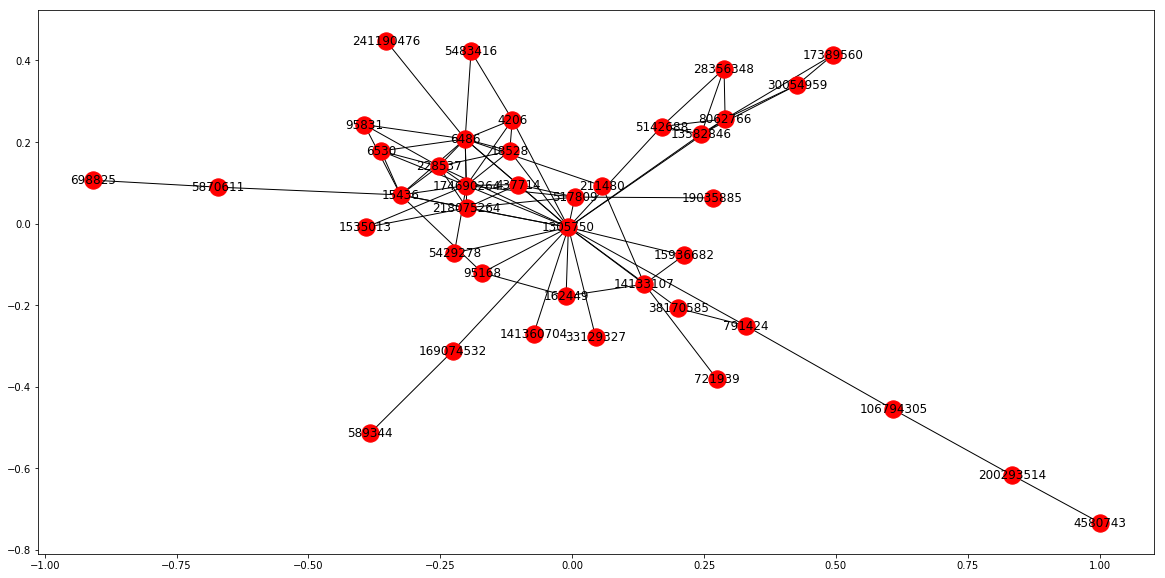

In [7]:
# Подгружаем пакеты для рисования
import matplotlib.pyplot as plt
%matplotlib inline

# Задаем побольше размер графика
plt.figure(figsize=(20, 10))

# Рисуем граф
nx.draw_networkx(G)

## Подписки на сообщества

К сожалению, некоторые методы ВКонтакте нельзя вызывать только с помощью сервисного ключа доступа. И процедура становится более сложной...

1. Вначале нужно перейти по следующей ссылке (вы должен быть залогинены на ВКонтакте). В ссылку нужно вставить **ID приложения** из раздела настройки, созданного Вами приложения https://oauth.vk.com/authorize?client_id=<Вставьте сюда **ID приложения** из раздела настройки>.

2. Произойдет переход на страницу с адресом вида https://oauth.vk.com/blank.html#code=<**код шага 2**>. Нужно скопировать этот код и перейти по еще одной ссылке...

3. В следующую ссылку нужно подставить полученные нами только что **код шага 2**, **ID приложения** из настроек и **защищённый ключ** тоже из настроек приложения. https://oauth.vk.com/access_token?client_id=<Вставьте сюда **ID приложения**>&client_secret=<Вставьте сюда **защищенный ключ**>&code=<Вставьте сюда **код из шага 2**>.

4. Наконец нужно будет скопировать access_token со страницы, на которую произойдет переход после шага 3.

На самом деле, этот процесс можно автоматизировать, но полученный код может быть гораздо сложнее отладить. Так что в учебных целях мы используем такой вариант.

In [8]:
ACCESS = "de26eeee166ee70dc06b828b30263652c371d3634f10e167f77509c674b79e8c80d729510346af3cc2c7f" # Не забудьте добавить кавычки

# Загрузим подписки друзей заданного пользователя.
# Эта процедура аналогична загрузке друзей.
# Нам нужно пересоздать переменную api теперь уже с ключом доступа другого типа,
# так как для подписок недостаточного сервисного ключа доступа
api = vk_requests.create_api(service_token = ACCESS)

groups = {}
i = 0
total = len(ego_friends)

# Перебираем друзей и загружаем для них подписки аналогично тому, что делали раньше
for friend in ego_friends:
    i += 1
    print(i, 'out of', total)
    try:
        # Загружаем для них группы, информация о методе доступна по ссылке https://vk.com/dev/groups.get
        time.sleep(0.34)
        result = api.groups.get(user_id = friend)        
        groups[friend] = result['items']
    except:
        print('Something is wrong')

1 out of 44
2 out of 44
3 out of 44
Something is wrong
4 out of 44
5 out of 44
Something is wrong
6 out of 44
7 out of 44
8 out of 44
9 out of 44
10 out of 44
11 out of 44
12 out of 44
13 out of 44
14 out of 44
15 out of 44
16 out of 44
17 out of 44
18 out of 44
19 out of 44
20 out of 44
21 out of 44
22 out of 44
23 out of 44
24 out of 44
25 out of 44
26 out of 44
27 out of 44
28 out of 44
Something is wrong
29 out of 44
30 out of 44
31 out of 44
32 out of 44
33 out of 44
Something is wrong
34 out of 44
35 out of 44
36 out of 44
37 out of 44
38 out of 44
39 out of 44
40 out of 44
41 out of 44
42 out of 44
43 out of 44
44 out of 44


In [9]:
# Посмотрим теперь, какие группы наиболее популярны среди друзей нашего пользователя.
# Информацию будем сохранять в переменной counter
counter = {}

# Ключи словарь groups это id пользователей ВКонтакте,
# а значения список id сообществ, на которые они подписаны
for friend in groups:
    # Перебираем по одной группе
    for group in groups[friend]:
        # Если такая группа еще не встречалась, то записываем стартовое значение ноль
        if group not in counter:
            counter[group] = 0
        # Увеличиваем счетчик
        counter[group] += 1

# Теперь мы хотим отсортировать словарь, но не знаем, как это сделать
# Первая ссылка в гугл по запросу sort dictionary python 
# дает ответ https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
ordered = sorted(counter.items(), key=lambda x: x[1])

# Выводим 10 самых популярных групп среди друзей пользователя
ordered[-10:]

[(34498598, 3),
 (23213239, 3),
 (26389816, 3),
 (46598842, 3),
 (16466790, 3),
 (23303030, 3),
 (3588818, 3),
 (46479096, 4),
 (26270763, 4),
 (263258, 6)]

In [12]:
# Но это были только id, мы можем вручную посмотреть, что это за группы,
# перейдя по ссылкам вида https://vk.com/public26389816.
# А можем автоматически скачать информацию используя API

top_groups = ordered[-10:]

# Превратим список id групп в строку, где они будут разделены через запятую
# Не забудем перевести их в строковый формат
top_groups = [str(x[0]) for x in top_groups]
top_groups_ids = ','.join(top_groups)

# Делаем запрос к API
result = api.groups.getById(group_ids = top_groups_ids)

for group in result:
    print(group['name'])

ВОС
Дзен
Петербург | Ретроспектива
Культура.РФ
Теории и практики
«Бумага»
Выпуск мат-мех ЛГУ 1979
Лаборатория "Социология образования и науки"
Интересные события в Санкт-Петербурге
Интернат №45 ЛГУ (АГ СПбГУ)


## Записи пользователей
В заключение протестируем относительно новую возможность ВКонтакте — [Streaming API](https://vk.com/dev/streaming_api). Она позволяет в режиме реального времени получать все, что пишется на ВКонтакте, содержащее заданный набор ключевых слов. По умолчанию возвращается только небольшая доля всех публикаций, но у ВКонтакте можно запросить доступ к полной выдаче. После запуска кода, вероятно, придется подождать какое-то время до появления первых записей. Так что можно пока отойти попить кофе.

В этом блоке кода есть бесконечный цикл, так что остановить выполнение нужно будет вручную.

Перед запуском кода нужно установить пакет [vkstreaming](https://github.com/SevereCloud/vk-streaming). Со страницы пакета можно взять блок кода ниже.

In [16]:
from vkstreaming import Streaming
import requests

def get_streaming_server_key(token):
    request_url = "https://api.vk.com/method/streaming.getServerUrl?access_token={}&v=5.64".format(token)
    r = requests.get(request_url)
    data = r.json()

    return {"server":data["response"]["endpoint"],"key":data["response"]["key"]}

response = get_streaming_server_key(SERVICE)
api = Streaming(response["server"], response["key"])

# Здесь мы добавляем интересующие нас слова.
# Можно посмотреть воспроизводится ли результат, полученный в https://arxiv.org/abs/1803.10329
api.del_all_rules()
api.add_rules('son', 'сын')
api.add_rules('daughter', 'дочь')

@api.stream
def my_func(event):
    text = event['text']
    text = text.replace('<br>', '\n')
    if len(text) > 300:
        text = text[:300] + '...'
    print(text)
    print('-' * 30)
api.start()

история на ночь

Две истории о похищенных пришельцами мальчиках 

Первая история была рассказана в паранормальном аудиоподкасте Paranormal Thoughts Podcast, в выпуске от 4 июля 2017 года. 

Адриан и Алекс 

В 2006 году Адриану было 14 лет и он с отцом в то лето поехали в гости к подруге отца. Они ос...
------------------------------


In [17]:
# На всякий случай, после завершения работы лучше удалить все правила
api.del_all_rules()